In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2025-07-14 20:39:49.660793: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752525589.875839      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752525589.939064      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#  Load dataset
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")

#  Prepare features and labels
X_train_full = train_data.drop("label", axis=1)
y_train_full = train_data["label"]

#  Normalize and reshape images
X_train = X_train_full / 255.0
X_test = test_data / 255.0
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)
y_train = y_train_full.astype("int")

#  Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


Train shape: (42000, 785), Test shape: (28000, 784)


In [3]:
#  Define Swish activation
def swish(x):
    return x * K.sigmoid(x)

#  Define Squeeze-and-Excitation block
def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(channels // reduction, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([input_tensor, se])

#  Define the CNN model architecture
def build_model():
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Conv2D(32, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Conv2D(64, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = se_block(x)
    x = layers.MaxPooling2D(2, 2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(swish)(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [4]:
# Image data augmentation
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)


 Fold 1


I0000 00:00:1752525673.542302      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752525673.543093      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752525682.734381      98 service.cc:148] XLA service 0x7d718003fa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752525682.735242      98 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752525682.735268      98 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752525683.503063      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


  7/525 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2124 - loss: 2.3271  

I0000 00:00:1752525690.213487      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


525/525 ━━━━━━━━━━━━━━━━━━━━ 30s 28ms/step - accuracy: 0.7961 - loss: 0.6476 - val_accuracy: 0.9823 - val_loss: 0.0682
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9624 - loss: 0.1295 - val_accuracy: 0.9860 - val_loss: 0.0467
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9751 - loss: 0.0832 - val_accuracy: 0.9900 - val_loss: 0.0307
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9762 - loss: 0.0770 - val_accuracy: 0.9867 - val_loss: 0.0458
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9790 - loss: 0.0696 - val_accuracy: 0.9917 - val_loss: 0.0308
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9814 - loss: 0.0597 - val_accuracy: 0.9918 - val_loss: 0.0309
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9825 - loss: 0.0565 - val_accuracy: 0.9920 - val_loss: 0.0326
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9841 - loss: 0.0507 - val_accurac

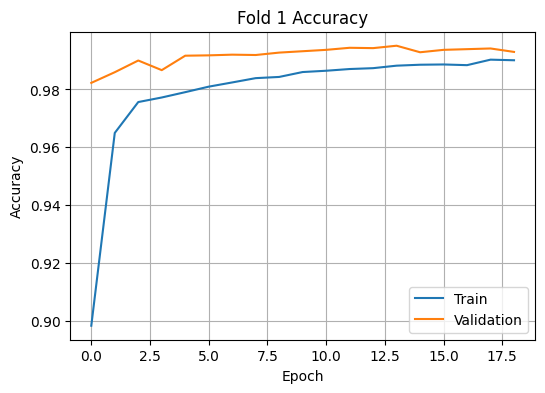


 Fold 2
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.7967 - loss: 0.6467 - val_accuracy: 0.9835 - val_loss: 0.0688
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9645 - loss: 0.1223 - val_accuracy: 0.9888 - val_loss: 0.0347
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9719 - loss: 0.0912 - val_accuracy: 0.9871 - val_loss: 0.0370
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9787 - loss: 0.0714 - val_accuracy: 0.9881 - val_loss: 0.0379
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.9816 - loss: 0.0613 - val_accuracy: 0.9905 - val_loss: 0.0283
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9826 - loss: 0.0610 - val_accuracy: 0.9920 - val_loss: 0.0285
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9820 - loss: 0.0569 - val_accuracy: 0.9881 - val_loss: 0.0364
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9826 - loss: 0.0547 - val_accurac

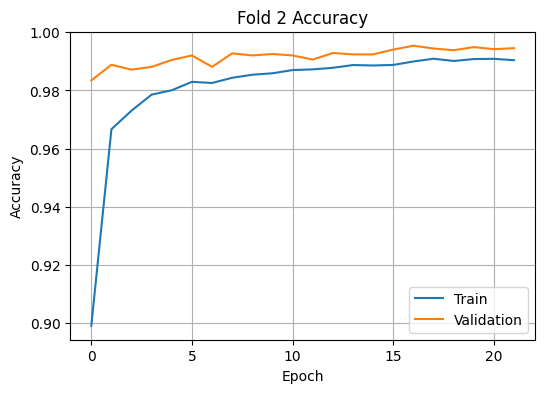


 Fold 3
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.7929 - loss: 0.6625 - val_accuracy: 0.9585 - val_loss: 0.1391
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9664 - loss: 0.1172 - val_accuracy: 0.9888 - val_loss: 0.0417
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9718 - loss: 0.0927 - val_accuracy: 0.9907 - val_loss: 0.0323
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9768 - loss: 0.0745 - val_accuracy: 0.9901 - val_loss: 0.0324
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9792 - loss: 0.0664 - val_accuracy: 0.9902 - val_loss: 0.0306
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9819 - loss: 0.0580 - val_accuracy: 0.9894 - val_loss: 0.0351
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9822 - loss: 0.0591 - val_accuracy: 0.9914 - val_loss: 0.0266
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9828 - loss: 0.0553 - val_accurac

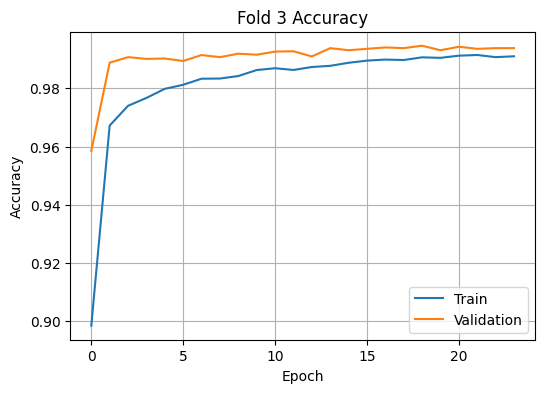


 Fold 4
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.8007 - loss: 0.6396 - val_accuracy: 0.9636 - val_loss: 0.1289
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9627 - loss: 0.1265 - val_accuracy: 0.9879 - val_loss: 0.0354
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9736 - loss: 0.0886 - val_accuracy: 0.9899 - val_loss: 0.0354
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9786 - loss: 0.0739 - val_accuracy: 0.9913 - val_loss: 0.0310
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9795 - loss: 0.0654 - val_accuracy: 0.9932 - val_loss: 0.0227
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9819 - loss: 0.0589 - val_accuracy: 0.9915 - val_loss: 0.0281
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9831 - loss: 0.0585 - val_accuracy: 0.9950 - val_loss: 0.0191
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9843 - loss: 0.0530 - val_accurac

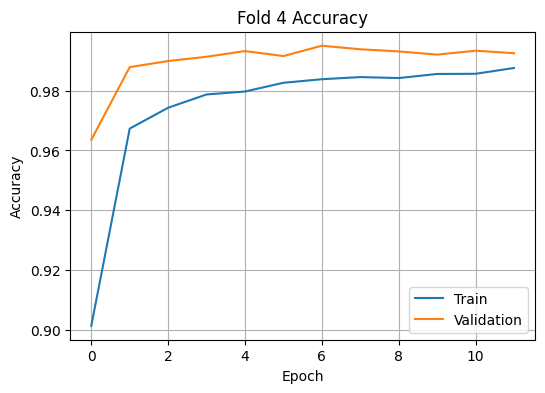


 Fold 5
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


525/525 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.7881 - loss: 0.6810 - val_accuracy: 0.9760 - val_loss: 0.0907
Epoch 2/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9632 - loss: 0.1264 - val_accuracy: 0.9883 - val_loss: 0.0355
Epoch 3/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9743 - loss: 0.0871 - val_accuracy: 0.9871 - val_loss: 0.0385
Epoch 4/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9793 - loss: 0.0696 - val_accuracy: 0.9892 - val_loss: 0.0358
Epoch 5/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9787 - loss: 0.0691 - val_accuracy: 0.9887 - val_loss: 0.0339
Epoch 6/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - accuracy: 0.9807 - loss: 0.0627 - val_accuracy: 0.9920 - val_loss: 0.0228
Epoch 7/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9833 - loss: 0.0537 - val_accuracy: 0.9935 - val_loss: 0.0218
Epoch 8/30
525/525 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.9842 - loss: 0.0490 - val_accurac

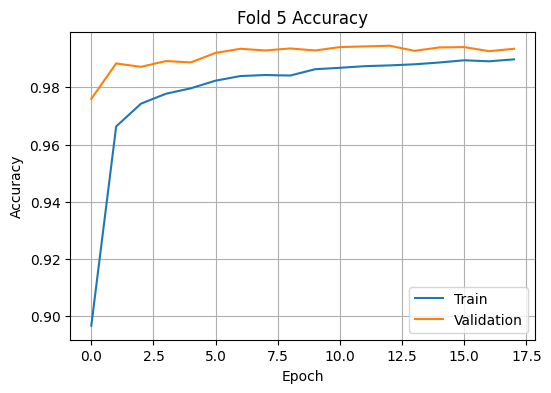


 Mean Accuracy: 0.9949


In [5]:
# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
models_list = []
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n Fold {fold + 1}")
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = build_model()
    aug.fit(X_tr)

    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    history = model.fit(
        aug.flow(X_tr, y_tr, batch_size=64),
        validation_data=(X_val, y_val),
        epochs=30,
        callbacks=[early_stop],
        verbose=1
    )

    #  Evaluate and store model
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    fold_accuracies.append(val_acc)
    models_list.append(model)
    print(f"Fold {fold + 1} Accuracy: {val_acc:.4f}")

    #  Plot training and validation accuracy per fold
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

#  Average accuracy from all folds
mean_acc = np.mean(fold_accuracies)
print(f"\n Mean Accuracy: {mean_acc:.4f}")

In [6]:
# Ensemble prediction on test set
print("\n Predicting using ensemble of models...")
all_preds = np.zeros((X_test.shape[0], 10))

for model in models_list:
    all_preds += model.predict(X_test, verbose=0)

ensemble_preds = np.argmax(all_preds / len(models_list), axis=1)



 Predicting using ensemble of models...


In [7]:
# Create submission file
submission = pd.DataFrame({
    "ImageId": np.arange(1, len(ensemble_preds) + 1),
    "Label": ensemble_preds
})
submission.to_csv("submission.csv", index=False)
print(" Submission saved as 'submission.csv'")

 Submission saved as 'submission.csv'


<Figure size 800x600 with 0 Axes>

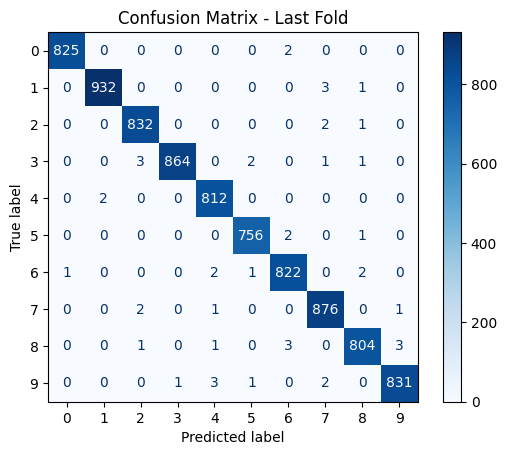

In [8]:
# Confusion Matrix using last fold validation set
last_model = models_list[-1]
y_val_preds = np.argmax(last_model.predict(X_val, verbose=0), axis=1)
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=np.arange(10)).plot(cmap="Blues")
plt.title("Confusion Matrix - Last Fold")
plt.grid(False)
plt.show()